(?, 1, 200, 64)
Epoch: 0001 cost= 8.028286934
Epoch: 0002 cost= 4.729882240
Epoch: 0003 cost= 7.557715416
Epoch: 0004 cost= 8.872577667
Epoch: 0005 cost= 4.702432632
Epoch: 0006 cost= 5.297564030
Epoch: 0007 cost= 23.399427414
Epoch: 0008 cost= 8.222093582
Epoch: 0009 cost= 6.725047112
Epoch: 0010 cost= 8.486409187
Epoch: 0011 cost= 7.758959293
Epoch: 0012 cost= 4.153004646
Epoch: 0013 cost= 6.454445839
Epoch: 0014 cost= 4.919779778
Epoch: 0015 cost= 9.220657349
Epoch: 0016 cost= 6.097871304
Epoch: 0017 cost= 7.037224293
Epoch: 0018 cost= 9.753604889
Epoch: 0019 cost= 11.587404251
Epoch: 0020 cost= 7.126347065
Epoch: 0021 cost= 5.429187298
Epoch: 0022 cost= 6.271872520
Epoch: 0023 cost= 9.358716011
Epoch: 0024 cost= 17.402778625
Epoch: 0025 cost= 6.005268574
Epoch: 0026 cost= 5.570568085
Epoch: 0027 cost= 7.902770519
Epoch: 0028 cost= 7.772303104
Epoch: 0029 cost= 9.115082741
Epoch: 0030 cost= 5.141946316
Epoch: 0031 cost= 8.537530899
Epoch: 0032 cost= 7.491311073
Epoch: 0033 cost= 5.8

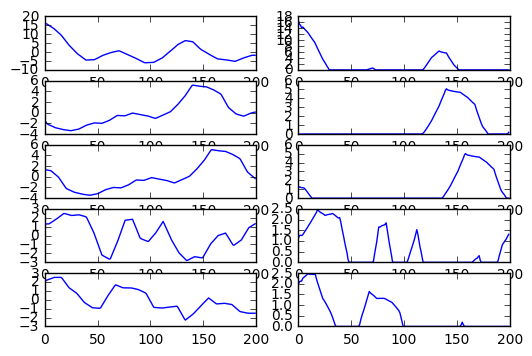

In [96]:
import tensorflow as tf
import os
from random import randint
import numpy as np
from numpy import newaxis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import MNIST data
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Parameters
learning_rate = 0.01
training_epochs = 250
batch_size = 100
display_step = 1
examples_to_show = 10

dirpath='/home/wenlu/Documents/XPFIFA/biopacMatchTransEnco8/'
matchfilels= os.listdir(dirpath)

def nextbatch(batchsize,sig=['hr'],seqlen=20,freq=10):
    header={'hr':0,'rsp':1,'eda':2,'emg_f':3,'emg_s':4,'acc':5}
    sel_f=[randint(0,len(matchfilels)-1) for p in range(10)] # select 10 from 348 files
    nb_in_file=int(batchsize/10)
    selectedfile=[dirpath+matchfilels[fidx] for fidx in sel_f]
    begls=[randint(0,2400-seqlen*freq) for p in range(nb_in_file)]
    batch=[np.genfromtxt(filei, delimiter=',', skip_header=beg+1, skip_footer=2400-(beg+seqlen*freq),usecols=tuple([header[i] for i in sig])) for filei in selectedfile for beg in begls]
    batchmat=np.asarray(batch)
    batchmat_de=batchmat-batchmat.mean(axis=1).reshape(-1,1)
    '''
    if len(sig)==1:
        return np.asarray(batch)[:, :, newaxis]
    else:
        return np.asarray(batch)
    '''
    return batchmat_de

    
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_1x2(x):
  return tf.nn.max_pool(x, ksize=[1, 1, 2, 1],
                        strides=[1, 1, 2, 1], padding='SAME')

# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    #layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),biases['encoder_b2']))
    
    W_conv1 = weight_variable([1, 5, 1, 64])
    b_conv1 = bias_variable([64])
    
    x_image = tf.reshape(x, [-1,1,200,1])
    
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    
    print(h_conv1.get_shape()) #(?, 1, 200, 64)
    '''h_pool1 = max_pool_1x2(h_conv1)
    print(h_pool1.get_shape())
    return h_pool1'''

    return h_conv1


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    #layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),biases['decoder_b2']))
    W_conv1 = weight_variable([1, 5, 64, 1])
    b_conv1 = bias_variable([1])
    
    #x_image = tf.reshape(x, [-1,1,200,64])
    
    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
    #print(h_conv1.get_shape())
    #h_pool1 = max_pool_1x2(h_conv1)
    #print(h_pool1.get_shape())
    #return h_pool1
    return h_conv1

X = tf.placeholder(tf.float32, shape=[None, 200])
y_true = tf.placeholder(tf.float32, shape=[None, 200])


saver = tf.train.Saver()

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
#print(decoder_op.get_shape())
# Targets (Labels) are the input data.
y_true = tf.reshape(X,[-1,1,200,1])

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    total_batch = 20
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: nextbatch(100)})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))
    save_path = saver.save(sess, "./tmp/model.ckpt")
    print("Model saved in file: %s" % save_path)
    print("Optimization Finished!")

    # Applying encode and decode over test set
    testset=nextbatch(100)
    encode_decode = sess.run(
        y_pred, feed_dict={X: testset})
    #print(encode_decode.shape)
    N=5
    for i in range(N):
        plt.subplot(N,2,i*2+1)
        plt.plot(range(200),testset[i])
        plt.subplot(N,2,i*2+2)
        plt.plot(range(200),np.squeeze(encode_decode, axis=(1,3))[i])
    plt.show()
          
    # Compare original images with their reconstructions


In [ ]:
import tensorflow as tf
import os
from random import randint
import numpy as np
from numpy import newaxis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import MNIST data
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Parameters
learning_rate = 0.01
training_epochs = 3
batch_size = 100
display_step = 1
examples_to_show = 10

dirpath='/home/wenlu/Documents/XPFIFA/biopacMatchTransEnco8/'
matchfilels= os.listdir(dirpath)

def nextbatch(batchsize,sig=['hr'],seqlen=20,freq=10):
    header={'hr':0,'rsp':1,'eda':2,'emg_f':3,'emg_s':4,'acc':5}
    sel_f=[randint(0,len(matchfilels)-1) for p in range(10)] # select 10 from 348 files
    nb_in_file=int(batchsize/10)
    selectedfile=[dirpath+matchfilels[fidx] for fidx in sel_f]
    begls=[randint(0,2400-seqlen*freq) for p in range(nb_in_file)]
    batch=[np.genfromtxt(filei, delimiter=',', skip_header=beg+1, skip_footer=2400-(beg+seqlen*freq),usecols=tuple([header[i] for i in sig])) for filei in selectedfile for beg in begls]
    batchmat=np.asarray(batch)
    batchmat_de=batchmat-batchmat.mean(axis=1).reshape(-1,1)
    '''
    if len(sig)==1:
        return np.asarray(batch)[:, :, newaxis]
    else:
        return np.asarray(batch)
    '''
    return batchmat_de

    
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_1x2(x):
  return tf.nn.max_pool(x, ksize=[1, 1, 2, 1],
                        strides=[1, 1, 2, 1], padding='SAME')

# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    #layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),biases['encoder_b2']))
    
    W_conv1 = weight_variable([1, 5, 1, 64])
    b_conv1 = bias_variable([64])
    x_image = tf.reshape(x, [-1,1,200,1])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    
    W_conv2 = weight_variable([1, 5, 64, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)
    #print(h_conv1.get_shape()) #(?, 1, 200, 64)
    '''h_pool1 = max_pool_1x2(h_conv1)
    print(h_pool1.get_shape())
    return h_pool1'''

    return h_conv2


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    #layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),biases['decoder_b2']))
    W_conv1 = weight_variable([1, 5, 64, 64])
    b_conv1 = bias_variable([64])
    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
    
    W_conv2 = weight_variable([1, 5, 64, 1])
    b_conv2 = bias_variable([1])
    h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)
    #print(h_conv1.get_shape())
    #h_pool1 = max_pool_1x2(h_conv1)
    #print(h_pool1.get_shape())
    #return h_pool1
    return h_conv2

X = tf.placeholder(tf.float32, shape=[None, 200])
y_true = tf.placeholder(tf.float32, shape=[None, 200])


saver = tf.train.Saver()

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
#print(decoder_op.get_shape())
# Targets (Labels) are the input data.
y_true = tf.reshape(X,[-1,1,200,1])

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    total_batch = 20
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: nextbatch(100)})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))
    save_path = saver.save(sess, "./tmp/model.ckpt")
    print("Model saved in file: %s" % save_path)
    print("Optimization Finished!")

    # Applying encode and decode over test set
    testset=nextbatch(100)
    encode_decode = sess.run(
        y_pred, feed_dict={X: testset})
    #print(encode_decode.shape)
    N=5
    for i in range(N):
        plt.subplot(N,2,i*2+1)
        plt.plot(range(200),testset[i])
        plt.subplot(N,2,i*2+2)
        plt.plot(range(200),np.squeeze(encode_decode, axis=(1,3))[i])
    plt.show()
          
    # Compare original images with their reconstructions


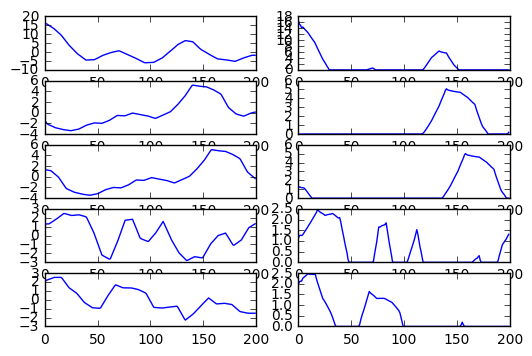

In [97]:
N=5
for i in range(N):
    plt.subplot(N,2,i*2+1)
    plt.plot(range(200),testset[i])
    plt.subplot(N,2,i*2+2)
    plt.plot(range(200),np.squeeze(encode_decode, axis=(1,3))[i])
plt.show()

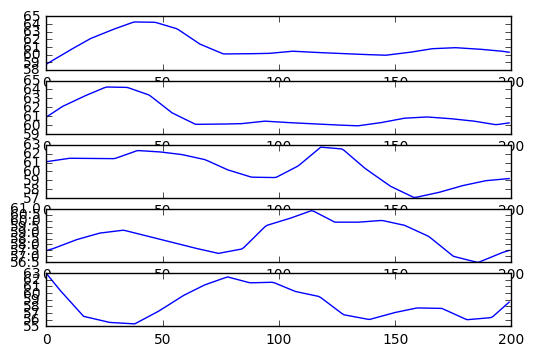

In [59]:
N=5
for i in range(N):
    plt.subplot(N,1,i+1)
    plt.plot(range(200),testset[i])
plt.show()

In [67]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Parameters
learning_rate = 0.01
training_epochs = 30
batch_size = 100
display_step = 1
examples_to_show = 10

# Network Parameters
n_hidden_1 = 128 # 1st layer num features
n_hidden_2 = 64 # 2nd layer num features
n_input = 200 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}


# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    total_batch = int(mnist.train.num_examples/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: nextbatch(100)})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")

    # Applying encode and decode over test set

    testset=nextbatch(100)
    encode_decode = sess.run(
        y_pred, feed_dict={X: testset})
    print(encode_decode.shape)
    N=5
    for i in range(N):
        plt.subplot(N,1,i+1)
        plt.subplot(N,2,i+1)
        plt.plot(range(200),testset[i])
        plt.plot(range(200),encode_decode[i])
    plt.show()
          

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Epoch: 0001 cost= 15.854269028
Epoch: 0002 cost= 13.133290291
Epoch: 0003 cost= 12.505602837
Epoch: 0004 cost= 11.429428101
Epoch: 0005 cost= 14.272965431
Epoch: 0006 cost= 12.273926735
Epoch: 0007 cost= 8.333101273
Epoch: 0008 cost= 10.358685493
Epoch: 0009 cost= 13.956032753
Epoch: 0010 cost= 10.976093292
Epoch: 0011 cost= 13.889607430


KeyboardInterrupt: 

In [120]:
import tensorflow as tf
import os
from random import randint
import numpy as np
from numpy import newaxis

dirpath='/home/wenlu/Documents/XPFIFA/biopacMatchTransEnco8/'
matchfilels= os.listdir(dirpath)
def nextbatch(batchsize,sig=['hr'],seqlen=20,freq=10):
    header={'hr':0,'rsp':1,'eda':2,'emg_f':3,'emg_s':4,'acc':5}
    sel_f=[randint(0,len(matchfilels)-1) for p in range(10)] # select 10 from 348 files
    nb_in_file=int(batchsize/10)
    selectedfile=[dirpath+matchfilels[fidx] for fidx in sel_f]
    begls=[randint(0,2400-seqlen*freq) for p in range(nb_in_file)]
    batch=[np.genfromtxt(filei, delimiter=',', skip_header=beg+1, skip_footer=2400-(beg+seqlen*freq),usecols=tuple([header[i] for i in sig])) for filei in selectedfile for beg in begls]
    
    if len(sig)==1:
        return np.asarray(batch)[:, :, newaxis]
    else:
        return np.asarray(batch)
    #return np.asarray(batch)
nextbatch(100,sig=['acc']).shape

(100, 200, 1)

In [19]:
#utf 16->8
bioMatchPath="./../biopacMatchTrans/"
bioMatchPathencoding8="./../biopacMatchTransEnco8/"

for sujet in range(2,59):
    for sequence in ['m11','m12','m21','m22','m31','m32']:
        fn='S'+str(sujet)+'_'+sequence+'.txt'
        matchFilename=bioMatchPath+fn
        outfile=bioMatchPathencoding8+fn
        #print fn
        try:
            source=open(matchFilename)
            target = open(outfile, "w")
            target.write(unicode(source.read(), "utf-16").encode("utf-8"))
        except:
            print fn+' not found'
            continue